<a href="https://colab.research.google.com/github/katieshaffer/user_event_data/blob/main/CompanyCam_Katie_Shaffer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and load the data

In [87]:
# Import pandas and sqlite
import pandas as pd
import sqlite3 as sqlite

In [88]:
# Load the prettytable module for making charts
!pip install prettytable==0.7.2
from prettytable import PrettyTable

# Import matplotlib package to make charts
import matplotlib.pyplot as plt

In [89]:
## Connect to GitHub repo with CSV files
!git clone https://github.com/katieshaffer/user_event_data

fatal: destination path 'user_event_data' already exists and is not an empty directory.


In [90]:
# Save CSVs as dataframes for later use

df_events = pd.read_csv('/content/user_event_data/assignment/dataset/event_data.csv')
df_subscriptions = pd.read_csv('/content/user_event_data/assignment/dataset/subscription_data.csv')
df_users = pd.read_csv('/content/user_event_data/assignment/dataset/user_data.csv')

In [91]:
# Load dataframes into SQLite database for querting

sql_data = 'D:\dataset.sqlite'
conn = sqlite.connect(sql_data)

df_events.to_sql('events', conn, if_exists='replace', index=False)
df_users.to_sql('users', conn, if_exists='replace', index=False)
df_subscriptions.to_sql('subscriptions', conn, if_exists='replace', index=False)

146

In [92]:
# Set up so SQL queries can be run in notebook
%load_ext sql
%sql sqlite:///D:\dataset.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Exploration of user data

In [93]:
## How many users are there?
%%sql

SELECT COUNT(DISTINCT user_id) AS num_users
FROM users
;

 * sqlite:///D:\dataset.sqlite
Done.


num_users
500


There are 500 total users.

In [94]:
## How many of each type?
%%sql

SELECT user_type,
       COUNT(DISTINCT user_id) AS num_users
FROM users
GROUP BY user_type
;

 * sqlite:///D:\dataset.sqlite
Done.


user_type,num_users
Free,354
Paid,146


Most of users (71%) are free users.

Assumption: Every user starts with a Free account and, if they update to Paid, we would update their `user_type` accordingly on the existing `user` record. As opposed to making a new row as a new "user" in that situation. So, assuming that Paid means they signed up after the free trial and Free means they did not (at least not yet).

In [95]:
## When did users signup?
%%sql

SELECT DATE(signup_date, 'start of month') as signup_month,
       COUNT(DISTINCT user_id) AS num_users
FROM users
GROUP BY signup_month
ORDER BY signup_month
;

 * sqlite:///D:\dataset.sqlite
Done.


signup_month,num_users
2023-06-01,80
2023-07-01,88
2023-08-01,71
2023-09-01,89
2023-10-01,102
2023-11-01,70


A bit of an uptick in signups in September/October. Were they mostly paid or free?

In [96]:
## How many users by type signed up each month?
%%sql

SELECT DATE(signup_date, 'start of month') as signup_month,
       SUM(CASE WHEN user_type = 'Free' THEN 1 ELSE 0 END) AS num_free_users,
       SUM(CASE WHEN user_type = 'Paid' THEN 1 ELSE 0 END) AS num_paid_users,
       COUNT(DISTINCT user_id) AS num_users
FROM users
GROUP BY signup_month
ORDER BY signup_month
;

 * sqlite:///D:\dataset.sqlite
Done.


signup_month,num_free_users,num_paid_users,num_users
2023-06-01,48,32,80
2023-07-01,59,29,88
2023-08-01,49,22,71
2023-09-01,68,21,89
2023-10-01,76,26,102
2023-11-01,54,16,70


I want to make a chart to see the changes over time by `user_type` more clearly.

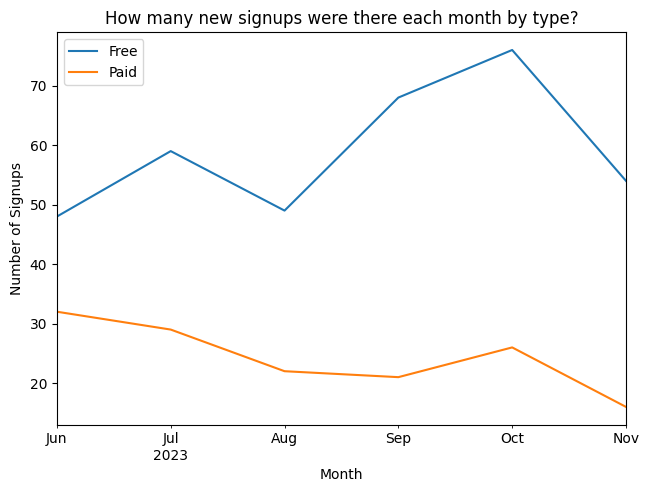

In [97]:
# Change `signup_date` in dataframe to a date and truncate to the month (equivalent to `DATE_TRUNC` in SQL)
df_users['signup_month'] = pd.to_datetime(df_users.signup_date.values.astype('datetime64[M]'))

my_pivot = df_users.pivot_table(values='user_id', index=['signup_month'], columns='user_type', aggfunc='count')
my_pivot.plot.line()
plt.tight_layout()
plt.title("How many new signups were there each month by type?")
plt.xlabel("Month")
plt.ylabel("Number of Signups")
plt.legend()
plt.show()

The increase in September and October was driven by Free signups. Paid signups have been trending down overall, while Free are trending up.

If my assumptions are correct, then conversion rate would be the number of signups who are now listed as `Paid` divided by the total number of signups for that timeframe. Then, the finding that (a) most users are free users, (b) paid users are decreasing, and (c) free users are increasing should mean that conversion is also decreasing.

In [98]:
%%sql

with signups as (
  SELECT DATE(signup_date, 'start of month') as signup_month,
        sum(case when user_type = 'Free' then 1 else 0 end) as free_signups,
        sum(case when user_type = 'Paid' then 1 else 0 end) as paid_signups,
        count(distinct user_id) as total_signups
  FROM users
  GROUP BY signup_month
)

select signup_month,
       paid_signups,
       free_signups,
       total_signups,
       ROUND(CAST(free_signups AS REAL) / CAST(total_signups AS REAL),2) as pct_churned_signups,
       ROUND(CAST(paid_signups AS REAL) / CAST(total_signups AS REAL),2) as pct_converted_signups
from signups
group by signup_month
order by signup_month
;

 * sqlite:///D:\dataset.sqlite
Done.


signup_month,paid_signups,free_signups,total_signups,pct_churned_signups,pct_converted_signups
2023-06-01,32,48,80,0.6,0.4
2023-07-01,29,59,88,0.67,0.33
2023-08-01,22,49,71,0.69,0.31
2023-09-01,21,68,89,0.76,0.24
2023-10-01,26,76,102,0.75,0.25
2023-11-01,16,54,70,0.77,0.23


Confirmed that conversoin rate has been decreasing each month.



## Exploraton of subscription data

In [99]:
## How many subscriptions are there?
%%sql
SELECT plan_type,
       COUNT(DISTINCT subscription_id) as num_subscriptions
FROM subscriptions
GROUP BY plan_type
;

 * sqlite:///D:\dataset.sqlite
Done.


plan_type,num_subscriptions
Pro,146


There are 146 subscriptions and all are Pro plan type. 146 is equal to the number of paid members.

Assumption: Only paid members show as subscriptions. Free users might be in a different table (such as a table showing free trials).

In [100]:
## Check assumption that users in `subscriptions` are the paid users from `users` table
%%sql
SELECT users.user_type,
       COUNT(DISTINCT subs.subscription_id) as num_subscriptions
FROM subscriptions as subs
LEFT JOIN users on subs.user_id = users.user_id
GROUP BY user_type
;

 * sqlite:///D:\dataset.sqlite
Done.


user_type,num_subscriptions
Paid,146


Assumption appears to be correct.

In [101]:
## How long does it usually take from a user signing up to subscribing?

%%sql
WITH days_to_sub AS (
  SELECT users.user_id,
         JULIANDAY(subs.start_date) - JULIANDAY(users.signup_date) as days_from_signup_to_subscribe
  FROM subscriptions as subs
  JOIN users on subs.user_id = users.user_id
)

SELECT ROUND(AVG(days_from_signup_to_subscribe),1) as avg_days_to_sub,
       MIN(days_from_signup_to_subscribe) as min_days_to_sub,
       MAX(days_from_signup_to_subscribe) as max_days_to_sub
FROM days_to_sub
;

 * sqlite:///D:\dataset.sqlite
Done.


avg_days_to_sub,min_days_to_sub,max_days_to_sub
15.6,1.0,29.0


SQLite doesn't have a built in median function, so skipping that for now. Normally I'd want to see how different the mean and median are to get an idea of the distribution and possible outliers. I am going to make a chart to look at this instead.

In [102]:
## How long does it usually take from a user signing up to subscribing?

# Run the query and save results in dataframe
query = """
WITH days_to_sub AS (
  SELECT users.user_id,
         JULIANDAY(subs.start_date) - JULIANDAY(users.signup_date) as days_from_signup_to_subscribe
  FROM subscriptions as subs
  JOIN users on subs.user_id = users.user_id
)

SELECT  days_from_signup_to_subscribe,
        COUNT(DISTINCT user_id) as num_users
FROM days_to_sub
GROUP BY days_from_signup_to_subscribe
ORDER BY days_from_signup_to_subscribe
;"""

result = %sql $query
df_signups = pd.DataFrame(result)


 * sqlite:///D:\dataset.sqlite
Done.


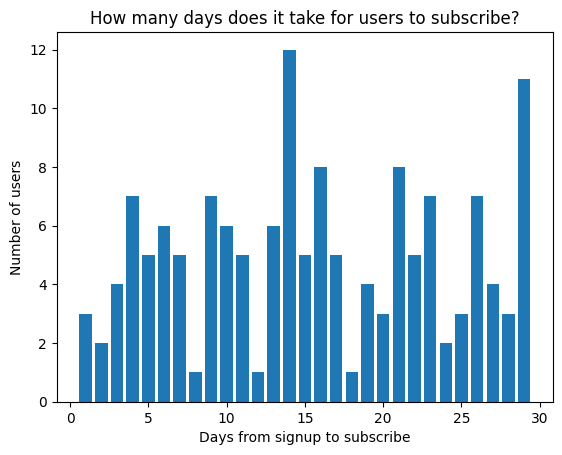

In [103]:
# Create the chart
plt.bar(df_signups.days_from_signup_to_subscribe, df_signups.num_users)

# Add labels and title
plt.xlabel("Days from signup to subscribe")
plt.ylabel("Number of users")
plt.title("How many days does it take for users to subscribe?")

# Show the plot
plt.show()

It's pretty variable how long it takes to sign up. There are jumps on day 14 and 29.

Assumption: There could be a free trial of 14 or 30 days and people sign up right before it ends. There is not enough information to verify this.

If someone needs to sign up within 30 days, then I would look at how many Free users signed up less than 30 days ago. These are users that may still convert. It also gives an idea of churn (how many won't convert). We already saw that all these signups were from 2023, so there are none within the last 30 days.

In [104]:
## How long do subscriptions typically last?
%%sql

WITH sub_length AS (
    SELECT subscription_id,
          JULIANDAY(end_date) - JULIANDAY(start_date) AS length_of_subscription_in_days
    FROM subscriptions
)

SELECT avg(length_of_subscription_in_days) as avg_length_of_subscription_in_days,
       min(length_of_subscription_in_days) as min_length_of_subscription_in_days,
       max(length_of_subscription_in_days) as max_length_of_subscription_in_days
FROM sub_length
;

 * sqlite:///D:\dataset.sqlite
Done.


avg_length_of_subscription_in_days,min_length_of_subscription_in_days,max_length_of_subscription_in_days
207.9931506849315,32.0,464.0


The average length of a subscription is 208 days (just under 7 months). However, the range is large, so there might be outliers impacting this. The minimum length is 32 days, which would be consistent with having to subscribe after 30 days (if someone signed up and canceled very shortly afterwards).

I would need to understand more about the data to make an interpretation.

In [105]:
## How long do subscriptions typically last?
%%sql

WITH sub_length AS (
    SELECT subscription_id,
          JULIANDAY(end_date) - JULIANDAY(start_date) AS length_of_subscription_in_days
    FROM subscriptions
)

SELECT CASE WHEN length_of_subscription_in_days < 30 THEN 'Less than 30 days'
            WHEN length_of_subscription_in_days BETWEEN 30 AND 59 THEN '30-59 days'
            WHEN length_of_subscription_in_days BETWEEN 60 AND 89 THEN '60-89 days'
            WHEN length_of_subscription_in_days BETWEEN 90 AND 119 THEN '90-119 days'
            WHEN length_of_subscription_in_days >= 120 THEN '120 days or more'
            ELSE null END AS length_of_subscription,
       COUNT(DISTINCT subscription_id) as num_subscriptions
FROM sub_length
GROUP BY length_of_subscription
;

 * sqlite:///D:\dataset.sqlite
Done.


length_of_subscription,num_subscriptions
120 days or more,95
30-59 days,16
60-89 days,14
90-119 days,21


It looks like users do have the option to cancel after 30 days based on the prior query (or possibly earlier, though there are no examples of that). However, it was uncommon for paid subscribers to cancel within the first 2 months. Of all paid subscriptions, 89% lasted at least 60 days.

If I had more time to complete this exercise, this analysis could be more accurate by looking at the start date. If they signed up near the end of the time period, they would logically have a shorter subscription length.

# Exploration of events data

In [106]:
## What event types do we have in the data?
%%sql

SELECT event_type,
       COUNT(DISTINCT event_id) as num_events,
       COUNT(DISTINCT user_id) as num_unique_users
FROM events
GROUP BY event_type
ORDER BY num_events DESC;

 * sqlite:///D:\dataset.sqlite
Done.


event_type,num_events,num_unique_users
Invite User,2758,485
Upload Photo,2677,480
Share Photo,2676,487
Login,2615,485
View Photo,2607,481


Roughly the same number of events and users for each type. I would have guessed that logging in would be the first event, but that doesn't appear to be true.

If there were an inherent order of events, we may want to build a funnel here. For example, if logging in is the first step, then how many logged in, how many viewed the next screen, etc.?

In [107]:
## How many events did we track by month?

%%sql
SELECT DATE(event_timestamp, 'start of month') as event_month, -- Despite name, not a timestamp
       COUNT(DISTINCT event_id) as num_events
FROM events
GROUP BY event_month
ORDER BY event_month;

 * sqlite:///D:\dataset.sqlite
Done.


event_month,num_events
2023-06-01,179
2023-07-01,550
2023-08-01,890
2023-09-01,1312
2023-10-01,1822
2023-11-01,2113
2023-12-01,2025
2024-01-01,1673
2024-02-01,1273
2024-03-01,932


There was a ramp up period from June to September (perhaps as event tracking was being implemented). Then, it started declining around January. It is possible that the decision was made to track fewer events or perhaps a certain type of event was deprecated/combined.

This is tangential to the main assignment, so I will not explore that further.

In [108]:
## How many events did Free and Paid users do?

%%sql

WITH events_by_user AS (
  SELECT users.user_id,
         users.user_type,
         COUNT(DISTINCT events.event_id) as num_events,
         COUNT(DISTINCT events.event_type) as num_types_of_events
  FROM events
  LEFT JOIN users on events.user_id = users.user_id
  WHERE JULIANDAY(events.event_timestamp) - JULIANDAY(users.signup_date) < 30 --Login occurred within 30 days of signup
  GROUP BY users.user_id,
           users.user_type
)

SELECT user_type,
       ROUND(AVG(num_events),1) as avg_events,
       ROUND(AVG(num_types_of_events),1) as avg_num_types_of_events
FROM events_by_user
GROUP BY user_type


 * sqlite:///D:\dataset.sqlite
Done.


user_type,avg_events,avg_num_types_of_events
Free,4.9,3.0
Paid,4.5,2.9


To make things more apples to apples, I limited my analysis to only events that happened within the first 30 days of signup for both free and paid users. (Otherwise, paid users would likely be much higher. Also, paid user behavior may be inherently different when using the product for real as opposed to trying it out as a test.)

Looking at the overall number of events, free users had a slightly higher average, though it might not be significant.

In [109]:
%%sql

WITH events_30_days AS (
  SELECT users.user_id,
         users.user_type,
         events.event_type,
         COUNT(DISTINCT events.event_id) as num_events
  FROM events
  LEFT JOIN users on events.user_id = users.user_id
  WHERE JULIANDAY(events.event_timestamp) - JULIANDAY(users.signup_date) < 30 --Login occurred within 30 days of signup
  GROUP BY users.user_id,
           users.user_type
)


SELECT user_type,
       event_type,
       SUM(num_events) as num_events,
       DENSE_RANK() OVER (PARTITION BY user_type ORDER BY SUM(num_events) DESC) as rank
FROM events_30_days
GROUP BY user_type,
         event_type
;


 * sqlite:///D:\dataset.sqlite
Done.


user_type,event_type,num_events,rank
Free,Invite User,399,1
Free,Upload Photo,348,2
Free,Login,340,3
Free,View Photo,294,4
Free,Share Photo,274,5
Paid,Upload Photo,168,1
Paid,Invite User,127,2
Paid,Login,126,3
Paid,Share Photo,111,4
Paid,View Photo,97,5


Uploading photos was the most common event for those who subscribed, while inviting users was most common for free users.

In [110]:
## Did event types change before and after subscribing?

%%sql
SELECT CASE WHEN event_timestamp >= start_date THEN 'On or after sub date'
            WHEN event_timestamp < start_date THEN 'Before sub date'
            ELSE null END AS event_timing,
       event_type,
       COUNT(DISTINCT event_id) as num_events
FROM events
INNER JOIN subscriptions on events.user_id = subscriptions.user_id
GROUP BY event_timing, event_type
ORDER BY event_timing, num_events DESC;

 * sqlite:///D:\dataset.sqlite
Done.


event_timing,event_type,num_events
Before sub date,Upload Photo,71
Before sub date,Invite User,71
Before sub date,Login,67
Before sub date,Share Photo,65
Before sub date,View Photo,62
On or after sub date,Invite User,725
On or after sub date,Share Photo,723
On or after sub date,Login,718
On or after sub date,View Photo,713
On or after sub date,Upload Photo,711


For users who went on to subscribe, the most common events changed in terms of ranking. However, the event types are still very evenly split, so this is likely not too meaningful of a difference.

In [111]:
## Did average number of logins differ by `user_type`?

%%sql

WITH logins AS (
  SELECT users.user_id,
         users.user_type,
         COUNT(DISTINCT events.event_id) as num_logins
  FROM events
  LEFT JOIN users on events.user_id = users.user_id
  WHERE event_type = 'Login'
  AND JULIANDAY(events.event_timestamp) - JULIANDAY(users.signup_date) < 30 --Login occurred within 30 days of signup
  GROUP BY users.user_id,
           users.user_type
)


SELECT user_type,
       ROUND(AVG(num_logins),1) as avg_logins
FROM logins
GROUP BY user_type
;

 * sqlite:///D:\dataset.sqlite
Done.


user_type,avg_logins
Free,1.6
Paid,1.6


Looking at both types of users, the average number of logins was the same within the first 30 days of sign up.

# SQL Challenge

### Write a SQL query to calculate the retention rate of users who signed up in the last three months of the max start_date.

This question is open for interpretation. For instance, does "signed up" mean created an account or started a subscription? The latter makes more sense from a business perspective, such as how many paid customers who subscribed in this time were still active on the end date?

I interpreted this question to mean I should:
* Find the most recent subscription date recorded overall in the table
* Pull a cohort of users who started a subscription in the 90 day period prior to (and including) that date
* Count how many still had a subscription as of the max date

In [112]:
# First, find the max `start_date` for the whole table. Then, look at users who signed up in the 90 days period prior to and including that date.
# How many still had a subscription at the end of that time (i.e., their `end_date` had not passed)?
%%sql

WITH subscription_dates AS (
  SELECT subscription_id,
         user_id,
         start_date,
         end_date,
         MAX(start_date) OVER () as max_start_date_for_table
  FROM subscriptions
  GROUP BY subscription_id,
        user_id,
        start_date,
        end_date
)

SELECT CASE WHEN end_date > max_start_date_for_table THEN TRUE ELSE FALSE END AS had_active_sub_at_end_of_period,
       COUNT(DISTINCT user_id) as num_users
FROM subscription_dates
WHERE JULIANDAY(max_start_date_for_table) - JULIANDAY(start_date) <= 90 -- Subscription started within last 3 months
GROUP BY had_active_sub_at_end_of_period
;

 * sqlite:///D:\dataset.sqlite
Done.


had_active_sub_at_end_of_period,num_users
0,4
1,50


54 users started a subscription in this time period and only 4 churned by the end of the timeframe. That is a 92% retention rate.

A total of 181 users signed up in this three month timespan. 44 became paid users, so the retention rate is 24%.

### Write a query to find the top three most frequently used features in the platform.

In [113]:
%%sql

WITH event_counts AS (
  SELECT event_type,
         COUNT(DISTINCT event_id) as num_events
  FROM events
  GROUP BY events.event_type
)


SELECT event_type,
       DENSE_RANK() OVER (ORDER BY num_events DESC) as event_rank
FROM event_counts
GROUP BY event_type
ORDER BY event_rank
LIMIT 3
;

 * sqlite:///D:\dataset.sqlite
Done.


event_type,event_rank
Invite User,1
Upload Photo,2
Share Photo,3


See Summary document for more information, including Experimentation and Data-Driven Recommendations.